# Установка библиотек

In [1]:
!pip install hazardous@git+https://github.com/soda-inria/hazardous
!pip install pycox
!pip install scikit-survival

  Cloning https://github.com/soda-inria/hazardous to /tmp/pip-install-4e6vdhph/hazardous_59fef01e92cf42c9b464c5aefb883327
  Running command git clone --filter=blob:none --quiet https://github.com/soda-inria/hazardous /tmp/pip-install-4e6vdhph/hazardous_59fef01e92cf42c9b464c5aefb883327
  Resolved https://github.com/soda-inria/hazardous to commit 36071a47bb5114e0e5ae529f6f471f18e3d23fae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached lifelines-0.30.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached autograd_gamma-0.5.0-py3-none-any.whl
  Using cached formulaic-1.1.1-py3-none-any.whl.metadata (6.9 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl.metadata (6.7 kB)
Using cached lifelines-0.30.0-py3-none-any.whl (349 kB)
Using cached formulaic-1.1.1-py3-none-any.whl (115 kB)
Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)
  Creat

In [2]:
from datetime import datetime
from hazardous import SurvivalBoost
from hazardous.metrics import integrated_brier_score_survival, integrated_brier_score_incidence
from lifelines import AalenJohansenFitter
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv
from pycox.models import DeepHit
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sksurv.metrics import check_y_survival, CensoringDistributionEstimator
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv
from typing import List
from zipfile import ZipFile
import io
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import os
import pandas as pd
import pandas as pd
import re
import seaborn as sns
import torch
import torchtuples as tt

# Подготовка данных

In [3]:
ibs = {}

In [4]:
dtypes = {'credit_score': 'Int16', 'first_payment_date': 'str', 'first_time_homebuyer_flag': 'str',
        'maturity_date': 'str', 'MSA': 'Int32', 'MI_%': 'Int16', 'units_numb': 'Int8', 'occupancy_status': 'str',
        'CLTV': 'Int16', 'DTI_ratio': 'Int16', 'orig_UPB': 'Int64', 'LTV': 'Int16', 'orig_interest_rate': 'str',
        'channel': 'str', 'PPM_flag': 'str', 'amortization_type': 'str',
        'property_state': 'str', 'property_type': 'str', 'postal_code': 'Int32', 'id_loan': 'str',
        'loan_purpose': 'str', 'orig_loan_term': 'Int16', 'borrowers_num': 'Int8', 'seller_name': 'str',
        'service_name': 'str', 'super_conf_flag': 'str', 'id_loan_preharp': 'str',
        'program_ind': 'str', 'HARP_ind': 'str', 'property_val_method': 'Int64',
        'int_only_flag': 'str', 'MI_cancel_flag': 'str', 'orig_interest_rate':'float32'}

static = ['credit_score', 'first_time_homebuyer_flag', 'units_numb', 'MSA', 'MI_%', 'occupancy_status', 'CLTV', 'DTI_ratio', 'orig_UPB',
       'LTV', 'orig_interest_rate', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'zero_balance_code', 'property_type', 'loan_purpose', 'orig_loan_term', 'borrowers_num', 'super_conf_flag',
       'int_only_flag', 'property_val_method']

categ = ['occupancy_status', 'first_time_homebuyer_flag', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'borrowers_num', 'int_only_flag', 'property_val_method', 'modification_flag', 'step_mod_flag', 'deferred_payment_plan',
         'ELTV', 'delinq_due_disaster', 'borrowe_asistance_stat_code', 'property_type', 'loan_purpose', 'super_conf_flag']


def get_y(cens, time):
    cens, time = np.array(cens), np.array(time)
    y = np.empty(dtype=[('event', int), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y


def get_y_event(y_, events: List=[]):
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=y_.shape[0])
    y['event'] = y_.event.isin(events)
    y['duration'] = y_.duration
    return y


def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))


def calc_short():
    file = r"D:\SurvivalAnalysis\CompetingRisk\files\result_short.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

In [5]:
y, X, sign, categ, df = calc_short()
df

,credit_score,first_time_homebuyer_flag,units_numb,MSA,MI_%,occupancy_status,CLTV,DTI_ratio,orig_UPB,LTV,...,zero_balance_code,property_type,loan_purpose,orig_loan_term,borrowers_num,super_conf_flag,int_only_flag,property_val_method,time,event
0,750,0,1,31540,0,0,74,32,101000,74,...,1.0,0,0,337,0,0,0,0,8,1
1,762,0,1,29100,0,0,54,27,112000,54,...,1.0,0,1,336,1,0,0,0,7,1
2,750,0,1,<NA>,0,0,49,21,188000,49,...,1.0,0,1,336,0,0,0,0,7,1
3,764,0,1,<NA>,0,0,62,44,149000,62,...,1.0,0,2,340,0,0,0,0,25,1
4,749,0,1,15940,30,0,93,41,84000,93,...,1.0,0,1,333,1,0,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,770,0,1,35614,0,0,62,65,155000,62,...,15.0,0,2,240,1,0,0,0,223,15
23996,682,0,1,39100,35,0,97,47,162000,97,...,15.0,0,1,360,1,0,0,0,223,15
23997,784,0,1,<NA>,0,0,71,45,161000,71,...,15.0,0,2,360,0,0,0,0,138,15
23998,738,0,1,15804,0,0,95,43,282000,80,...,15.0,0,1,360,1,0,0,0,213,15


In [6]:
y_ = pd.DataFrame(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, stratify=y_.event, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train.event, random_state = 1)

<Axes: xlabel='duration', ylabel='Density'>

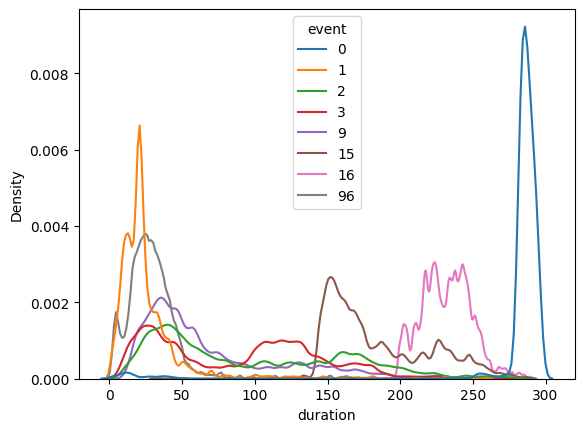

In [7]:
sns.kdeplot(data=y_train, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

# Модели

##AalenJohansenFitter (lifelines)



/usr/local/lib/python3.11/dist-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
         

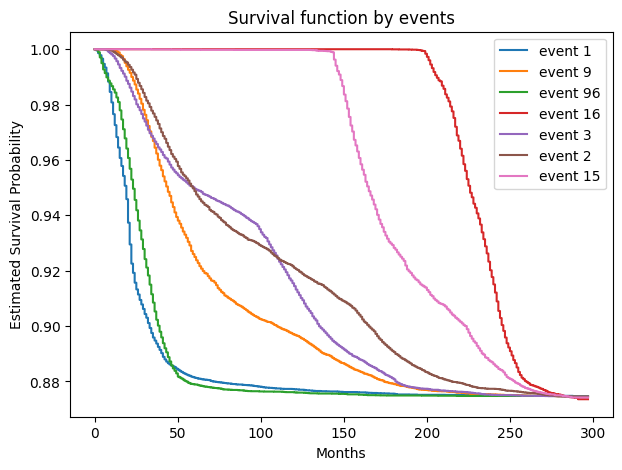

In [ ]:
aj = AalenJohansenFitter()
T, E = y_.duration, y_.event
fig, ax_ = plt.subplots(figsize=(7, 5))
scores=[]
for i in df.event.unique():
  if i:
    aj.fit(T, E, event_of_interest=i)
    ibs_ = ibs_remain(get_y_event(y_train, [i]),
                      get_y_event(y_test, [i]),
                      1-aj.cumulative_density_[f'CIF_{i}'],
                      times=aj.cumulative_density_.index, axis=-1)
    scores.append(ibs_)
    print(f"ibs {ev}: {ibs_}")
    ax_.plot(aj.cumulative_density_.index,
             1-aj.cumulative_density_[f'CIF_{i}'],
             label=(f"event {i}"),
    )
ax_.legend()
ax_.set_title("Survival function by events")
ax_.set_xlabel("Months")
ax_.set_ylabel("Estimated Survival Probability")

plt.show()

## SurvivalBoost (hazardous)

In [ ]:
survival_boost = SurvivalBoost(show_progressbar=True).fit(x_train, y_train)

100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


In [ ]:
x_ = x_test.copy()
x_.MSA.fillna(0, inplace=True)

<ipython-input-15-bc696d1b0baf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_.MSA.fillna(0, inplace=True)


ibs 1: 0.06298488948084602
ibs 9: 0.06892742899747555
ibs 96: 0.06318149134652701
ibs 16: 0.08384914420328486
ibs 3: 0.07199420137132072
ibs 2: 0.07583198895593486
ibs 15: 0.08079051010123929
---------
 ibs: 0.05799123794851943


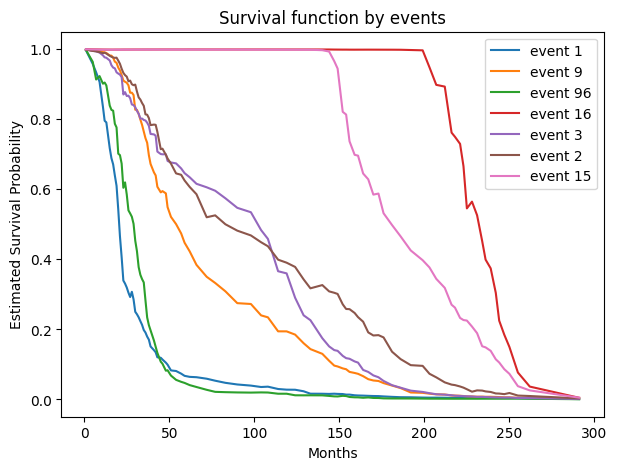

In [ ]:
curves = survival_boost.predict_survival_function(x_)
fig, ax = plt.subplots(figsize=(7, 5))
scores=[]
for ev in df.event.unique():
  if ev:
    mask = y_test["event"] == ev
    mean_survival = curves[mask].mean(axis=0)
    ibs_ = ibs_remain(get_y_event(y_train, [ev]), get_y_event(y_test, [ev]), curves, times=survival_boost.time_grid_, axis=-1)
    scores.append(ibs_)
    print(f"ibs {ev}: {ibs_}")
    ax.plot(
        survival_boost.time_grid_,
        mean_survival,
        label=(f"event {ev}"),
    )
ibs_ = ibs_remain(get_y_event(y_train, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]), curves, times=survival_boost.time_grid_, axis=-1)
scores.append(ibs_)
print('---------\n', f"ibs: {ibs_}")
ibs['SurvivalBoost']=scores
ax.legend()
ax.set_title("Survival function by events")
ax.set_xlabel("Months")
ax.set_ylabel("Estimated Survival Probability")

plt.show()

## DeepHit (pycox)

In [8]:
get_x = lambda df: (df.values.astype('float32'))
get_target = lambda df: (df['duration'].values, df['event'].values)


class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')


class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [9]:
x_val.MSA.fillna(0, inplace=True)
x_test.MSA.fillna(0, inplace=True)
x_train.MSA.fillna(0, inplace=True)


labtrans = LabTransform(100)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_ = labtrans.fit_transform(*get_target(y_train.sort_values(by='duration')))
y_val = labtrans.transform(*get_target(y_val))
durations_test, events_test = get_target(y_test)
x_train = get_x(x_train)
x_val = get_x(x_val)
x_test = get_x(x_test)
val = (x_val, y_val)
train = (x_train, y_train_)

in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = y_train_[1].max()
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
                duration_index=labtrans.cuts)

<ipython-input-9-0231e84b36a5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_val.MSA.fillna(0, inplace=True)
<ipython-input-9-0231e84b36a5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col

In [10]:
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = True
#x_train_ = x_train_.astype('int64')
log = model.fit(x_train, y_train_, batch_size, epochs, callbacks, verbose, val_data=val)

/usr/local/lib/python3.11/dist-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  p.data = p.data.add(-weight_decay * eta, p.data)


0:	[30s / 30s],		train_loss: 1.8948,	val_loss: 1.7728
1:	[11s / 42s],		train_loss: 1.5141,	val_loss: 1.4523
2:	[15s / 57s],		train_loss: 1.4309,	val_loss: 1.4496
3:	[12s / 1m:9s],		train_loss: 1.4298,	val_loss: 1.4396
4:	[13s / 1m:22s],		train_loss: 1.4235,	val_loss: 1.4413
5:	[10s / 1m:33s],		train_loss: 1.4149,	val_loss: 1.4403
6:	[11s / 1m:45s],		train_loss: 1.4098,	val_loss: 1.4407
7:	[11s / 1m:56s],		train_loss: 1.4195,	val_loss: 1.4447
8:	[20s / 2m:17s],		train_loss: 1.4157,	val_loss: 1.4533
9:	[13s / 2m:31s],		train_loss: 1.4122,	val_loss: 1.4449
10:	[9s / 2m:40s],		train_loss: 1.4095,	val_loss: 1.4439
11:	[11s / 2m:52s],		train_loss: 1.4064,	val_loss: 1.4449
12:	[10s / 3m:2s],		train_loss: 1.4046,	val_loss: 1.4749
13:	[10s / 3m:12s],		train_loss: 1.4030,	val_loss: 1.4710
14:	[10s / 3m:22s],		train_loss: 1.3998,	val_loss: 1.4934
15:	[10s / 3m:33s],		train_loss: 1.4102,	val_loss: 1.4513


/usr/local/lib/python3.11/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


In [11]:
cif = model.predict_cif(x_test)

cif - трехмерный массив размера (96, 100, 4800), где

*   axis=0 - тип события, от 0 до 95 (используется только 8, zero_code-1 соотв.)
*   axis=1 - временная шкала
*   axis=2 - соответствующие наблюдения



ibs 1: 0.21884723080911236
ibs 9: 0.20058401266874842
ibs 96: 0.22084340274681466
ibs 16: 0.09776629059953135
ibs 3: 0.19015556757496727
ibs 2: 0.1873199327557945
ibs 15: 0.13797071636142325
---------
 ibs: 0.4702423635867105


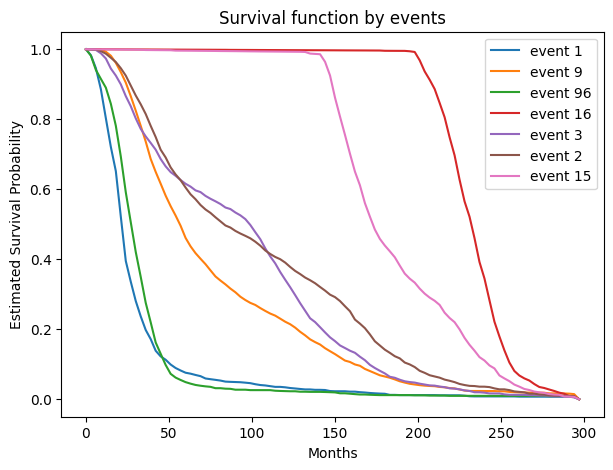

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
scores=[]
summ=np.empty(shape=model.duration_index.shape)
y_tmp = pd.DataFrame({'event': y_train_[1], 'duration': y_train_[0]})
for i in df.event.unique():
  if i:
    tmp = (cif.transpose()[..., i-1]).mean(axis=0)
    summ += tmp
    ibs_ = ibs_remain(get_y_event(y_tmp, [i]),
                      get_y_event(y_test, [i]),
                      1-cif.transpose()[..., i-1], times=model.duration_index, axis=-1)
    scores.append(ibs_)
    print(f"ibs {i}: {ibs_}")
    tmp = (tmp-np.min(tmp))/(np.max(tmp)-np.min(tmp))
    ax.plot(model.duration_index,
          1-tmp,
          label=f"event {i}")
est = cif.transpose()[..., sorted(df.event.unique()-1)[1:]].mean(axis=2)
ibs_ = ibs_remain(get_y_event(y_tmp, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]),
                  1-est, times=model.duration_index, axis=-1)
scores.append(ibs_)
print('---------\n', f"ibs: {ibs_}")
ibs['DeepHit']=scores
ax.legend()
ax.set_title("Survival function by events")
ax.set_xlabel("Months")
ax.set_ylabel("Estimated Survival Probability")

plt.show()

Здесь использовалось линейное преобразование  оси Y в [0, 1], т.к. cif_k <= 0.12 (+-) (т.к. $\sum_{k}cif_k + S(t) = 1$) (Аналогично в AalenJohansen, но там осталось 0.12)

---

ниже график S(t)

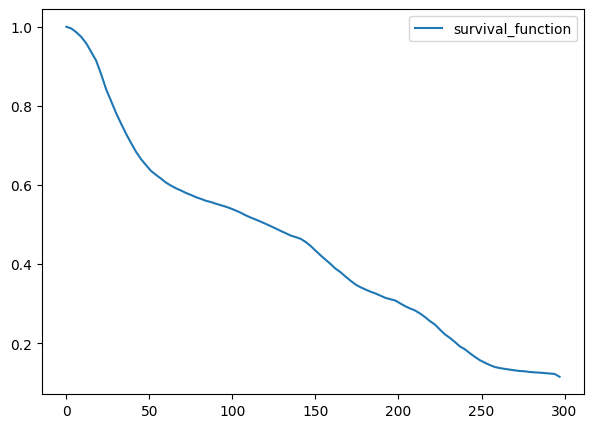

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(model.duration_index,
          1-summ,
          label=f"survival_function")
ax.legend()
plt.show()

## IBS

In [13]:
def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    """ IBS with equal impact of partial observation with controlled quantity """
    test_event, test_time = check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return brier_scores
    return None

In [ ]:
ibs_tab = pd.DataFrame(ibs, index=[f'ibs_{i}' for i in sorted(df.event.unique())[1:]]+['IBS'])
ibs_tab

,SurvivalBoost,DeepHit
ibs_1,0.062985,0.205334
ibs_2,0.068927,0.201941
ibs_3,0.063181,0.223562
ibs_9,0.083849,0.098006
ibs_15,0.071994,0.191378
ibs_16,0.075832,0.187696
ibs_96,0.080791,0.138025
IBS,0.057991,0.466167
